## Ocean Biogeochemical Dynamics Lab, Spring 2021
Doing CO2SYS Calculations with SOCCOM floats by Nancy Williams

This assumes you have already become familiar with `OBD_SOCCOM_L3.ipynb` notebook

This code covers importing, cleaning, and plotting data from a single SOCCOM float in the Southern Ocean as well as CO2SYS calculations. 

SOCCOM website: https://soccom.princeton.edu/

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import seaborn as sns # this will change the look of pandas plots, too
import cartopy.crs as ccrs
import cartopy.feature
import seawater
import xarray as xr
from PyCO2SYS.api import CO2SYS_wrap as co2sys
import os
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15,9)
plt.rcParams['font.size'] = 18
#plt.rcParams['lines.linewidth'] = 3
# this forces matplotlib to print figures out here when you make plots
from IPython.display import Image

# Press Shift + Enter to "run" this cell and move on to the next one 

In [5]:
# Define the directory where you want the figures to be saved
output_dir = 'generated/'

# Importing the dataset
We want to use Pandas' built-in read_csv function to import a single float data file into a pandas data frame called `flt`. Float 9254 is a good example float, but you can pick any float from the snapshot. To pick another float you can go to the SOCCOM web page sensor status table http://soccom.ucsd.edu/floats/SOCCOM_sensor_stats.html and choose a float with lots of good data (i.e., more in the "#g" column than the "#b" columns for variables you're interested in analyzing. You can sort the columns on that webpage by clicking on the column header by which you wish to sort.

In [48]:
# Pick a float
floatnum='9091' 
floatpath='SOCCOM_LoResQC_LIAR_22Dec2020_odvtxt/' # This is the folder where all the float data live
floatsuffix='SOOCNQC.TXT' # all of the Southern Ocean floats have the same suffix

In [49]:
# Change // comment symbols to #
# input file
fin = open(floatpath+floatnum+floatsuffix,'rt',encoding='UTF-8')

# output file to which we will write the result
fout = open('fltrem.txt','wt')

# this is a for loop
# for each line in the input file
for line in fin:
    # red and replace the string and write to the output file
    fout.write(line.replace('//','#'))
# close the files
fin.close()
fout.close()

In [50]:
flt=pd.read_csv('fltrem.txt',delimiter='\t',comment='#',na_values=-1E10)
flt['date']=pd.to_datetime(flt['mon/day/yr']+' '+ flt['hh:mm'])

In [51]:
# Loop through all Quality Flag columns and apply them to the preceeding columns
from re import search
for column in range(len(flt.columns)):
    name=flt.columns[column]
    if search('QF',name): # if the column is a QF column, apply it to the preceeding column, otherwise go on to next column
        var=flt.columns[column-1]
        flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)

# Mapping your data
It's always a good idea to map your data and make sure it is where you think it is. Here we will use cartopy (basemap is deprecated).

Since we're talking about the Southern Ocean and there are stark fronts, it's good to plot your data in relation to these fronts. The climatological locations of the fronts are available from Orsi et al. (1995) https://www.sciencedirect.com/science/article/pii/096706379500021W. Text files containing the locations of the fronts are located in the "fronts" folder.

### Where is your float in relation to the fronts of the ACC?
The following code imports the longitudes and latitudes of the five fronts. There are some '%' values in the files which creates breaks in the fronts. If we did not keep these breaks, the fronts would plot across continents.

In [52]:
stf=pd.read_csv('fronts/stf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
saf=pd.read_csv('fronts/saf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
pf=pd.read_csv('fronts/pf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
saccf=pd.read_csv('fronts/saccf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
sbdy=pd.read_csv('fronts/sbdy.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])

### Cartopy
The following is an example of a South Polar Stereographic map using Cartopy https://scitools.org.uk/cartopy/docs/latest/#. Polar stereographic maps are always a bit more complicated because you have to translate your coordinates to polar coordinates.

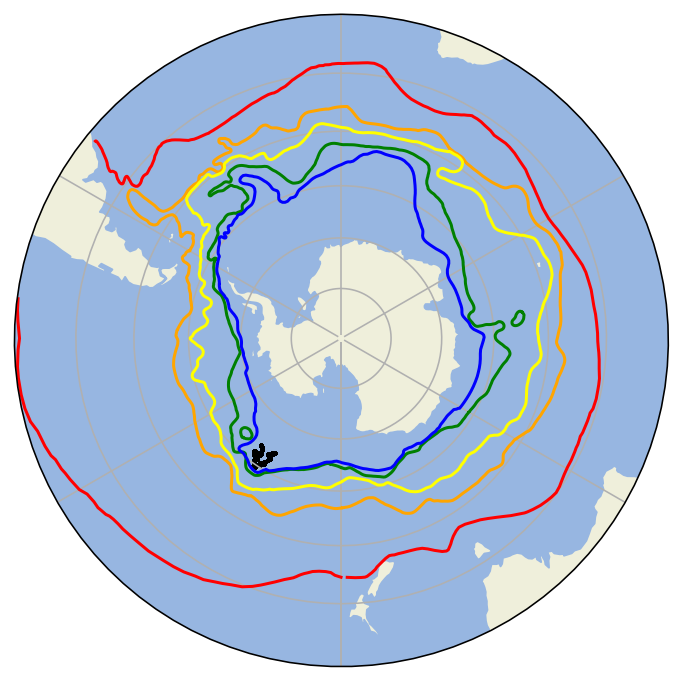

In [53]:
plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180,180,-90,-30],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
plt.plot(stf['lon'],stf['lat'],color='Red',transform=ccrs.PlateCarree())
plt.plot(saf['lon'],saf['lat'],color='Orange',transform=ccrs.PlateCarree())
plt.plot(pf['lon'],pf['lat'],color='Yellow',transform=ccrs.PlateCarree())
plt.plot(saccf['lon'],saccf['lat'],color='Green',transform=ccrs.PlateCarree())
plt.plot(sbdy['lon'],sbdy['lat'],color='Blue',transform=ccrs.PlateCarree())

plt.scatter(flt['Lon [°E]'],flt['Lat [°N]'],color='Black',transform=ccrs.PlateCarree(), s=1)
plt.savefig(output_dir+'F'+floatnum+'map.png') 
plt.savefig(output_dir+'F'+floatnum+'map.jpg') # Changing the suffix will change the format
plt.show()


In [54]:
# Calculate MLD for each station
MLD=[]
for station in flt['Station'].unique():
    surfacedens=flt['Sigma_theta[kg/m^3]'].loc[(flt['Station']==station)].min()
    MLD.append([station,flt['date'].loc[(flt['Station']==station)&(flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
                flt['Depth[m]'].loc[(flt['Station']==station)&(flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
              flt['Lon [°E]'].loc[(flt['Station']==station)].mean(),
              flt['Lat [°N]'].loc[(flt['Station']==station)].mean()])

# Take a look at MLD. First column is the Station, second column is datenum, second column is the MLD
MLD = pd.DataFrame(data=MLD, columns=['Station', 'date', 'MLD','Lon [°E]','Lat [°N]'])

## Do some CO2SYS calculations using Pyco2

In [55]:
# Do an example
# Call with defaults
df1 = co2sys(dic=2103, alk=2360)

# The above is equivalent to:
df1 = co2sys(
    dic=2103, alk=2360, pco2=None, fco2=None, pH=None,
    carb=None, bicarb=None, co2aq=None,
    temp_in=25, temp_out=25, pres_in=0, pres_out=0,
    sal=35, si=0, po4=0, nh3=0, h2s=0,
    K1K2_constants=4, KSO4_constants=1, KF_constant=1, pHscale_in=1,
    buffers_mode="auto", verbose=True)

Convert data to pandas.DataFrame
Removing nans for efficiency
Computing CO2 parameters
Insert nans back into DataFrame
Convert data to pandas.DataFrame
Removing nans for efficiency
Computing CO2 parameters
Insert nans back into DataFrame


In [56]:
df1 = co2sys(
    pH=flt['pHinsitu[Total]'], alk=flt['TALK_LIAR[µmol/kg]'],
    temp_in=flt['Temperature[°C]'], temp_out=flt['Temperature[°C]'],
    pres_in=flt['Pressure[dbar]'], pres_out=flt['Pressure[dbar]'],
    sal=flt['Salinity[pss]'], si=0, po4=0, nh3=0, h2s=0,
    K1K2_constants=10, KSO4_constants=1, KF_constant=1, pHscale_in=1,
    buffers_mode="auto", verbose=True)

df1

Convert data to pandas.DataFrame
Removing nans for efficiency
Computing CO2 parameters
Insert nans back into DataFrame


,TAlk,TCO2,pHin,pCO2in,fCO2in,HCO3in,CO3in,CO2in,BAlkin,OHin,...,PAR1TYPE,PAR2TYPE,K1K2CONSTANTS,KSO4CONSTANTS,KSO4CONSTANT,KFCONSTANT,BORON,pHSCALEIN,buffers_mode,WhichR
0,2353.0,2274.079093,7.8557,542.538758,540.177369,2169.187163,71.786384,33.105546,39.823703,0.430522,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
1,2351.0,2272.361069,7.8584,544.982354,542.611691,2167.373251,71.788122,33.199696,39.633040,0.431535,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
2,2354.0,2275.419786,7.8614,548.088828,545.706117,2170.079973,72.009902,33.329911,39.481133,0.433065,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
3,2355.0,2276.326419,7.8650,550.071340,547.681605,2170.676240,72.263967,33.386212,39.374383,0.435304,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
4,2355.0,2276.162603,7.8688,551.434187,549.040129,2170.231381,72.526434,33.404788,39.291678,0.437813,...,1,3,10,1,1.0,1,1.0,1,auto,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
flt['OmegaAr']=df1['OmegaARout']
flt

,Cruise,Station,Type,mon/day/yr,hh:mm,Lon [°E],Lat [°N],QF,Pressure[dbar],QF.1,...,pH25C[Total],QF.15,TALK_LIAR[µmol/kg],QF.16,DIC_LIAR[µmol/kg],QF.17,pCO2_LIAR[µatm],QF.18,date,OmegaAr
0,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,1399.38,0.0,...,7.5605,0.0,2353.0,0.0,2269.0,0.0,533.2,0.0,2014-04-03 22:50:00,0.821805
1,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,1298.38,0.0,...,7.5598,0.0,2351.0,0.0,2268.0,0.0,535.8,0.0,2014-04-03 22:50:00,0.838161
2,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,1199.53,0.0,...,7.5594,0.0,2354.0,0.0,2271.0,0.0,538.8,0.0,2014-04-03 22:50:00,0.857136
3,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,1098.49,0.0,...,7.5595,0.0,2355.0,0.0,2272.0,0.0,540.8,0.0,2014-04-03 22:50:00,0.877326
4,5904184,1,C,04/03/2014,22:50,209.965,-63.973,0,999.27,0.0,...,7.5600,0.0,2355.0,0.0,2272.0,0.0,542.1,0.0,2014-04-03 22:50:00,0.897789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,5904184,153,C,07/18/2018,23:57,217.015,-63.635,0,19.52,0.0,...,NaN,8.0,2298.0,0.0,NaN,8.0,NaN,1.0,2018-07-18 23:57:00,NaN
9905,5904184,153,C,07/18/2018,23:57,217.015,-63.635,0,16.41,0.0,...,NaN,8.0,2299.0,0.0,NaN,8.0,NaN,1.0,2018-07-18 23:57:00,NaN
9906,5904184,153,C,07/18/2018,23:57,217.015,-63.635,0,11.16,0.0,...,NaN,8.0,2299.0,0.0,NaN,8.0,NaN,1.0,2018-07-18 23:57:00,NaN
9907,5904184,153,C,07/18/2018,23:57,217.015,-63.635,0,5.53,0.0,...,NaN,8.0,2299.0,0.0,NaN,8.0,NaN,1.0,2018-07-18 23:57:00,NaN


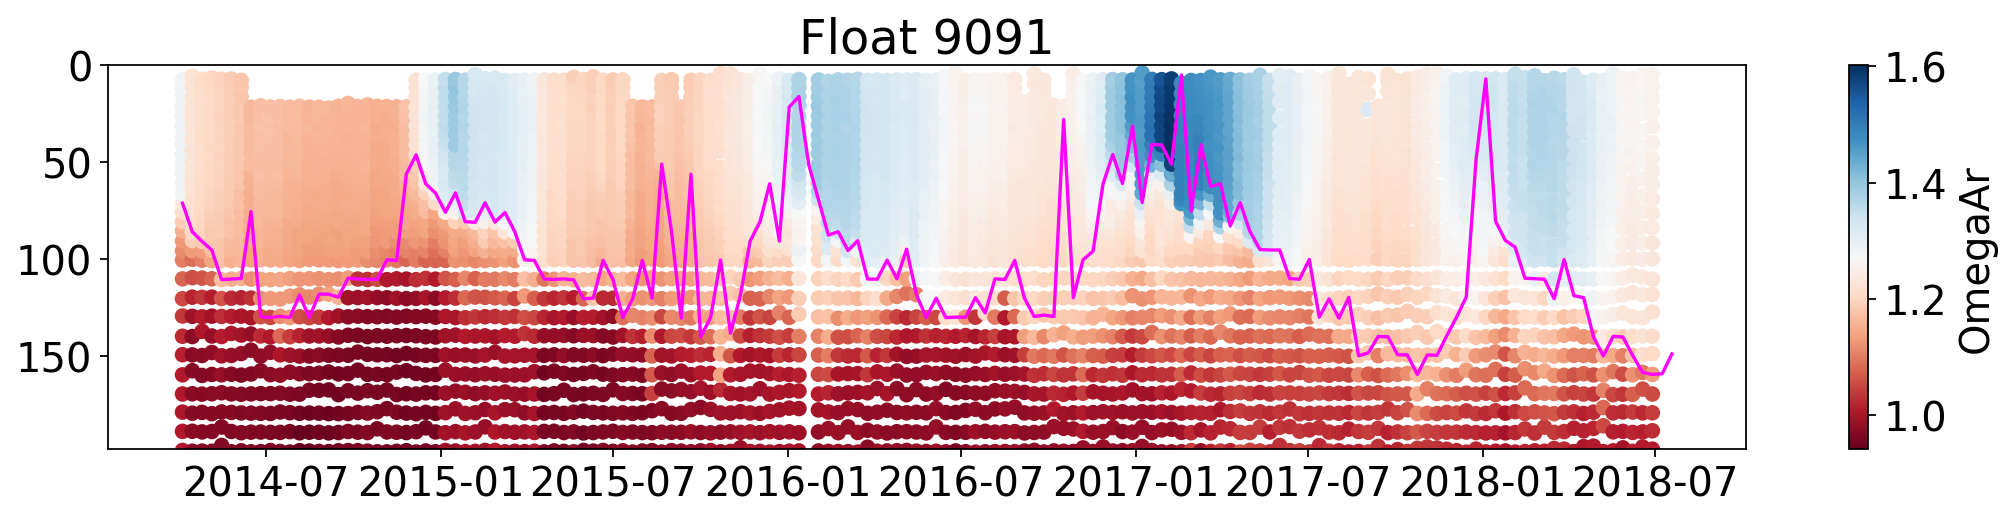

In [58]:
# Next look at the saturation state of aragonite (Omega_Ar) you calculated
var='OmegaAr'
fig = plt.figure(num=None, figsize=(16,3), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'RdBu')
ax.plot(MLD['date'],MLD['MLD'],c='magenta')
ax.invert_yaxis()
ax.set_title('Float '+floatnum)
ax.set_ylim([depth,0])
cb=plt.colorbar(sc)
cb.set_label(var)
# automatically adjusts the colorbar based on the range of values youre plotting
sc.set_clim(vmin = flt[var].loc[(flt['Depth[m]']<depth)].min(), 
            vmax = flt[var].loc[(flt['Depth[m]']<depth)].max()) 
fig.savefig(output_dir+'F'+floatnum+var[0:3]+'section.png', dpi = 200, bbox_inches='tight')

## Make a time series plot of average top 30 m observations
Here we use the pandas groupby function to group the near-surface data by station.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [59]:
# Need to work on this loop to use actual MLD instead of 30 m for averaging
#fltSurf=pd.DataFrame()
#for station in MLD['Station'].unique():
#    stationMLD=MLD['MLD'].loc[(MLD['Station']==station)]
#    mask=flt.loc[(flt['Station']==station),(flt['Pressure[dbar]']<stationMLD)]
#    fltSurf=fltSurf.append(flt[mask])

In [60]:
fltSurf=flt.loc[(flt['Pressure[dbar]']<30)]
fltSurfByStn=fltSurf.groupby('Station').mean()

In [61]:
# Groupby doesn't work on datetime column so it was dropped. We need to make a datetime array to be used with plotting
fltdates=[]
for station in flt['Station'].unique():
    fltdates.append([flt['date'].loc[(flt['Station']==station)].min()])
len(fltdates)

153

In [62]:
# Unfortunately, sometimes the fltdates is 1 row longer than the groupby file. 
# Not sure how/why this happened but for now, we will just assume that 
# there is an extra date somewhere and drop the final date.
# Need to fix this later. It might lead to a 10-day error in the dates
if len(fltdates)>len(fltSurfByStn):
    fltdates.pop()# pop "pops off" the last value

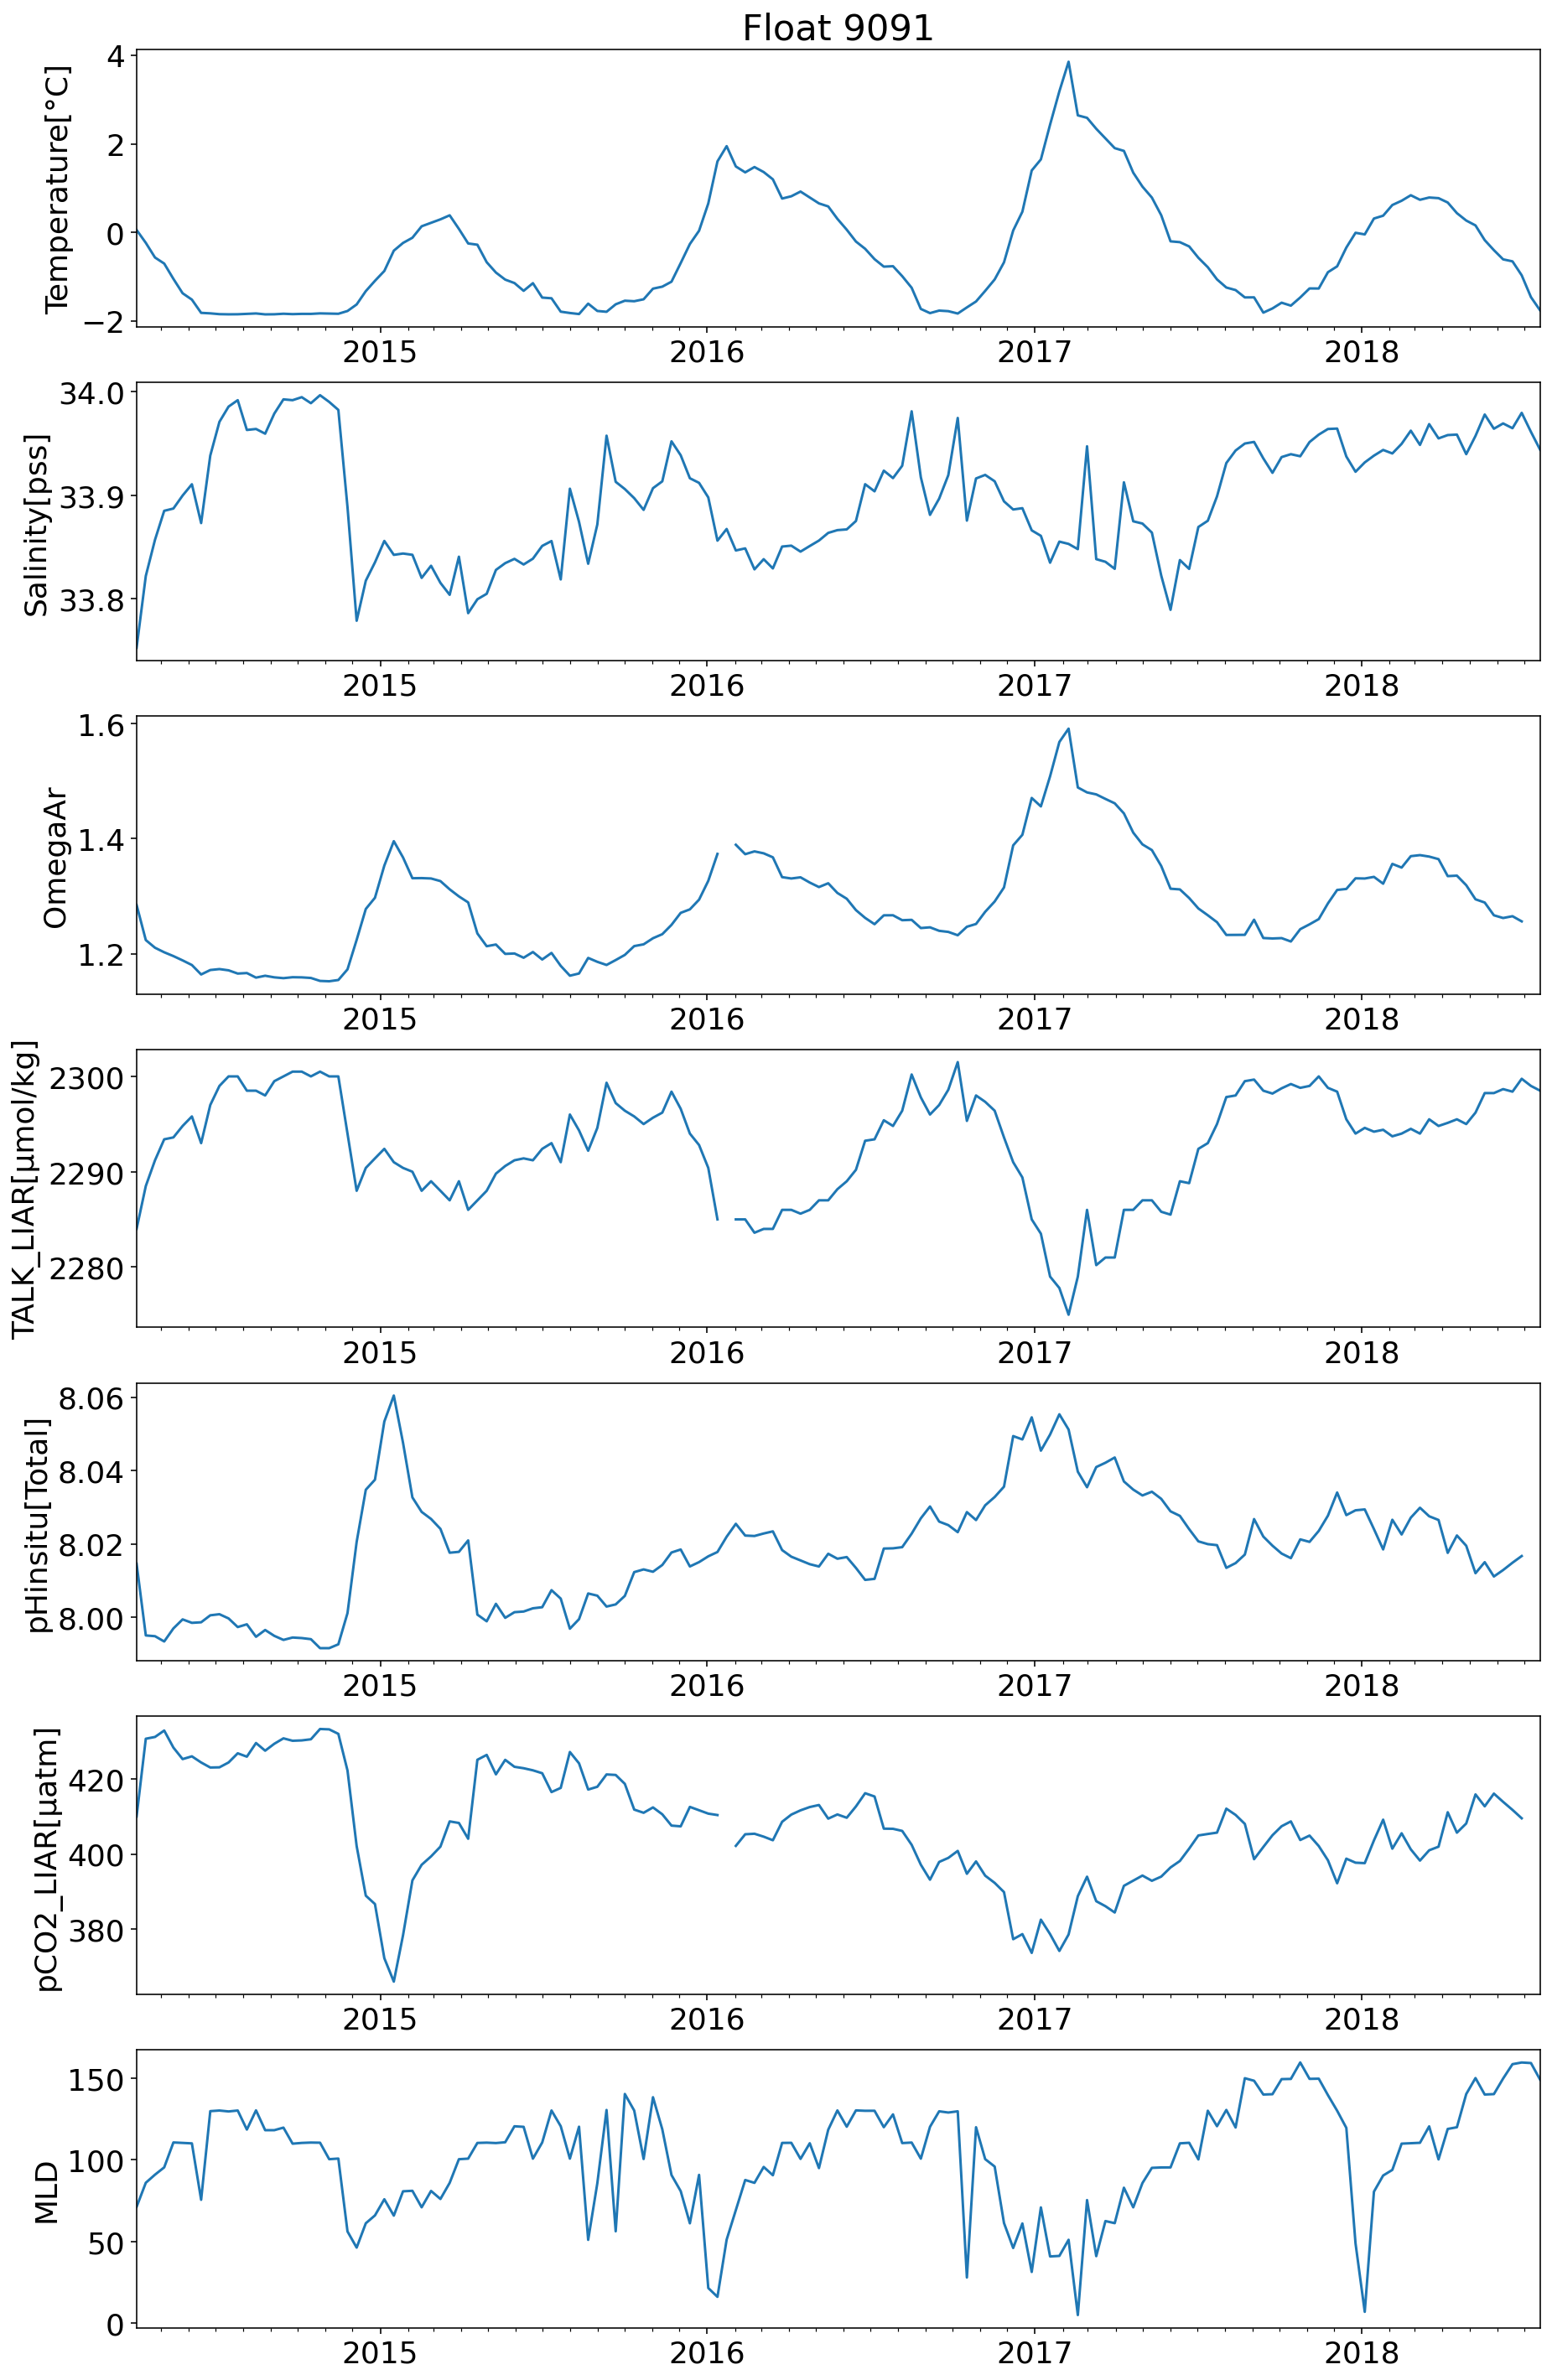

In [63]:
# Make a big plot with subplots
fig,axes = plt.subplots(nrows = 7, ncols = 1,figsize=(15,25))
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

var='Temperature[°C]'
axes[0].plot(fltdates,fltSurfByStn[var])
axes[0].set_ylabel(var)
axes[0].set_xlim(fltdates[0],fltdates[-1])
# format the ticks
axes[0].xaxis.set_major_locator(years)
axes[0].xaxis.set_major_formatter(years_fmt)
axes[0].xaxis.set_minor_locator(months)

var='Salinity[pss]'
axes[1].plot(fltdates,fltSurfByStn[var])
axes[1].set_ylabel(var)
axes[1].set_xlim(fltdates[0],fltdates[-1])
axes[1].xaxis.set_major_locator(years)
axes[1].xaxis.set_major_formatter(years_fmt)
axes[1].xaxis.set_minor_locator(months)

var='OmegaAr'
axes[2].plot(fltdates,fltSurfByStn[var])
axes[2].set_ylabel(var)
axes[2].set_xlim(fltdates[0],fltdates[-1])
axes[2].xaxis.set_major_locator(years)
axes[2].xaxis.set_major_formatter(years_fmt)
axes[2].xaxis.set_minor_locator(months)

var='TALK_LIAR[µmol/kg]'
axes[3].plot(fltdates,fltSurfByStn[var])
axes[3].set_ylabel(var)
axes[3].set_xlim(fltdates[0],fltdates[-1])
axes[3].xaxis.set_major_locator(years)
axes[3].xaxis.set_major_formatter(years_fmt)
axes[3].xaxis.set_minor_locator(months)

var='pHinsitu[Total]'
axes[4].plot(fltdates,fltSurfByStn[var])
axes[4].set_ylabel(var)
axes[4].set_xlim(fltdates[0],fltdates[-1])
axes[4].xaxis.set_major_locator(years)
axes[4].xaxis.set_major_formatter(years_fmt)
axes[4].xaxis.set_minor_locator(months)

var='pCO2_LIAR[µatm]'
axes[5].plot(fltdates,fltSurfByStn[var])
axes[5].set_ylabel(var)
axes[5].set_xlim(fltdates[0],fltdates[-1])
axes[5].xaxis.set_major_locator(years)
axes[5].xaxis.set_major_formatter(years_fmt)
axes[5].xaxis.set_minor_locator(months)

var='MLD'
axes[6].plot(MLD['date'],MLD['MLD'])
axes[6].set_ylabel(var)
axes[6].set_xlim(fltdates[0],fltdates[-1])
axes[6].xaxis.set_major_locator(years)
axes[6].xaxis.set_major_formatter(years_fmt)
axes[6].xaxis.set_minor_locator(months)

axes[0].set_title('Float '+floatnum)
# This is the first figure we're saving. We have given it a name, a type, and a dpi or
# dots per inch which is resolution
fig.savefig(output_dir+'F'+floatnum+'CO2SYS.png', dpi = 200, bbox_inches='tight')